In [1]:
%run Prepare_Python.ipynb

## 0. Basic usage

There are two required arguments:

- the first argument is expected to be a dataframe with both group indicator variables and covariates,
- the second argument specifies a list with names of column which indicate the group membership.

Additional arguments can be provided, such as `name` (specifies xlab for intersection matrix) or `width_ratio` (specifies how much space should be occupied by the set size panel). Other such arguments are discussed at length later in this document.

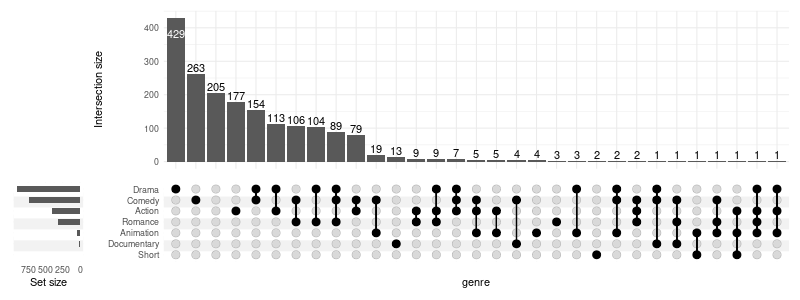

In [2]:
%%R -w 800 -h 300
upset(movies, genres, name='genre', width_ratio=0.1)

### 0.1 Selecting intersections by size

We will focus on the intersections with at least ten members `(min_size=10)` and on a few variables which are significantly different between the intersections (see 2. Running statistical tests).

When using `min_size`, the empty groups will be skipped by default (e.g. *Short* movies would have no overlap with size of 10). To keep all groups pass `keep_empty_groups=TRUE`:

[1] "Dropping empty groups: Short"


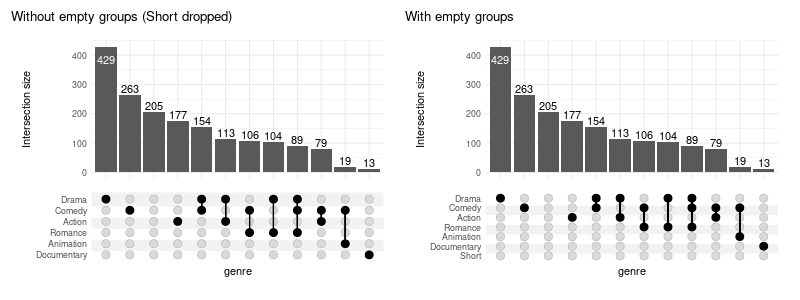

In [3]:
%%R -w 800 -h 300
(
    upset(movies, genres, name='genre', width_ratio=0.1, min_size=10, wrap=TRUE, set_sizes=FALSE)
    + ggtitle('Without empty groups (Short dropped)')
    +    # adding plots is possible thanks to patchwork
    upset(movies, genres, name='genre', width_ratio=0.1, min_size=10, keep_empty_groups=TRUE, wrap=TRUE, set_sizes=FALSE)
    + ggtitle('With empty groups')
)

When empty columns are detected a warning will be issued. The silence it, pass `warn_when_dropping_groups=FALSE`.

## 1. Adding components

We can add multiple annotation components (also called panels):

[1] "Dropping empty groups: Short"


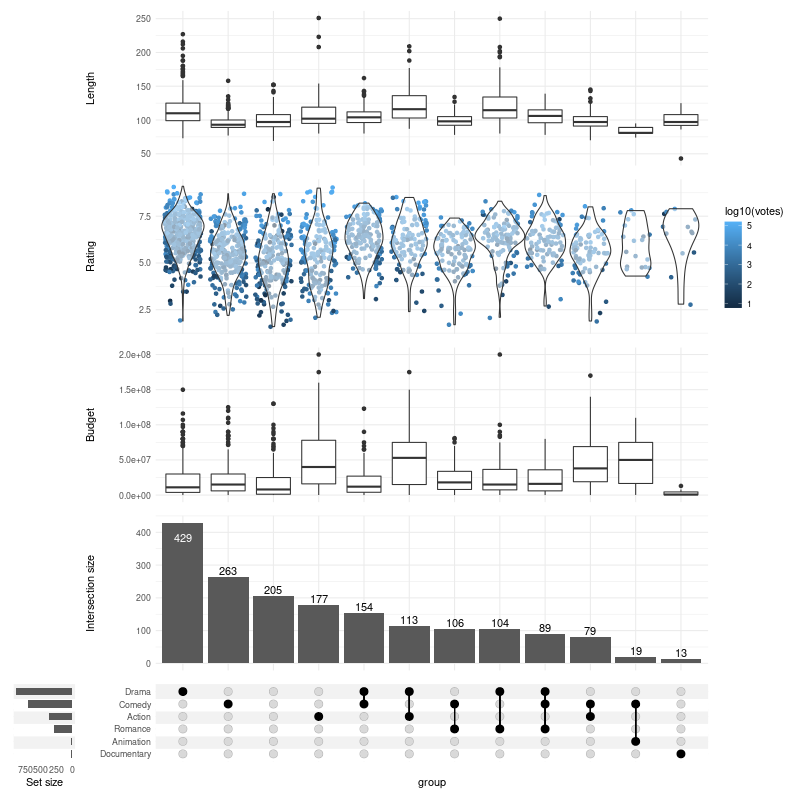

In [4]:
%%R -w 800 -h 800

set.seed(0)   # keep the same jitter for identical plots

upset(
    movies,
    genres,
    annotations = list(
        'Length'=list(
            aes=aes(x=intersection, y=length),
            geom=geom_boxplot()
        ),
        'Rating'=list(
            aes=aes(x=intersection, y=rating),
            geom=list(
                # checkout ggbeeswarm::geom_quasirandom for better results!
                geom_jitter(aes(color=log10(votes))),
                geom_violin(width=1.1, alpha=0.5)
            )
        ),
        'Budget'=list(
            aes=aes(x=intersection, y=budget),
            geom=geom_boxplot()
        )
    ),
    min_size=10,
    width_ratio=0.1
)

For simple annotations, such as the length above, you can use a shorthand notation of `upset_annotate`:

[1] "Dropping empty groups: Short"


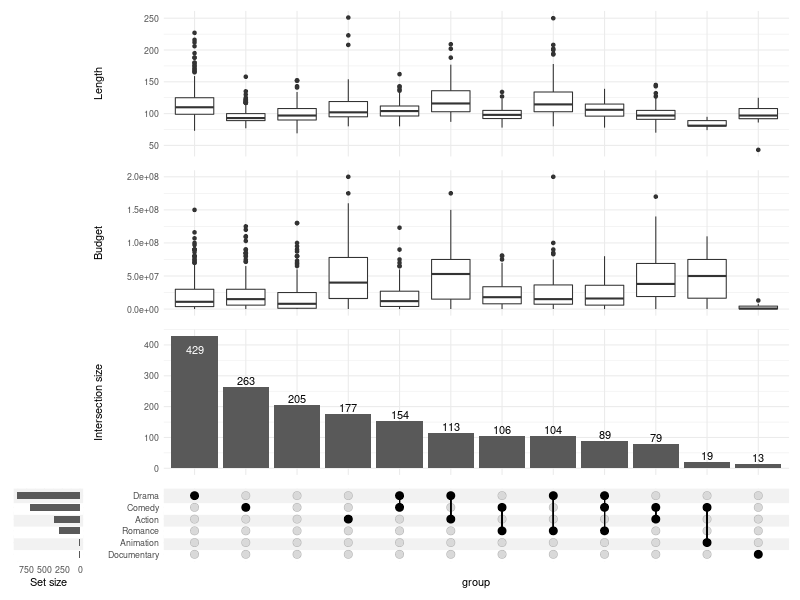

In [5]:
%%R -w 800 -h 600

upset(
    movies,
    genres,
    annotations = list(
        'Length'=upset_annotate('length', geom_boxplot()),
        'Budget'=upset_annotate('budget', geom_boxplot())
    ),
    min_size=10,
    width_ratio=0.1
)

You can also use barplots to demonstrate differences in proportions of categorical variables:

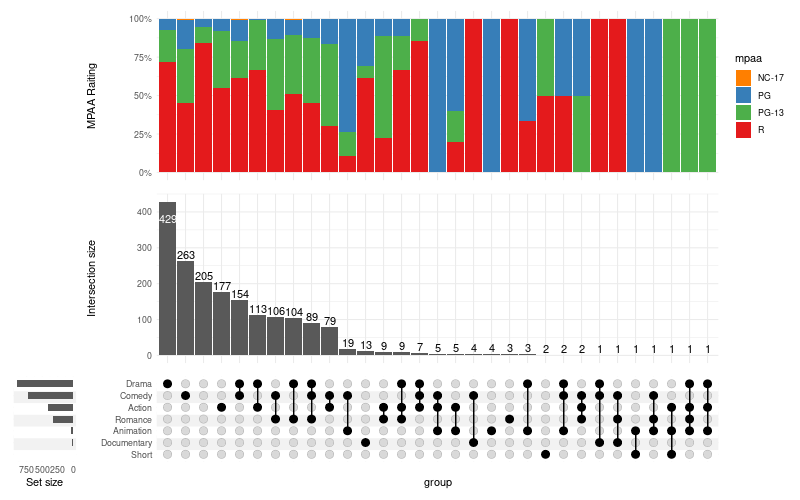

In [6]:
%%R -w 800 -h 500

upset(
    movies,
    genres,
    annotations = list(
        'MPAA Raiting'=list(
            aes=aes(x=intersection, fill=mpaa),
            geom=list(
                geom_bar(stat='count', position='fill'),
                scale_y_continuous(labels=scales::percent_format()),
                scale_fill_manual(values=c(
                    'R'='#E41A1C', 'PG'='#377EB8',
                    'PG-13'='#4DAF4A', 'NC-17'='#FF7F00'
                ))
            )
        )
    ),
    width_ratio=0.1
)

## 2. Running statistical tests

In [7]:
%R upset_test(movies, genres)

[1] "year, length, budget, rating, votes, r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, mpaa differ significantly between intersections"


,variable,p.value,statistic,test,fdr
length,length,6.511525e-71,422.884445,Kruskal-Wallis rank sum test,1.106959e-69
rating,rating,1.209027e-46,301.727638,Kruskal-Wallis rank sum test,1.027673e-45
budget,budget,3.899860e-44,288.974760,Kruskal-Wallis rank sum test,2.209921e-43
r8,r8,9.900004e-39,261.288151,Kruskal-Wallis rank sum test,4.207502e-38
mpaa,mpaa,3.732200e-35,242.779393,Kruskal-Wallis rank sum test,1.268948e-34
r9,r9,1.433256e-30,218.781602,Kruskal-Wallis rank sum test,4.060891e-30
r1,r1,2.211600e-23,180.327398,Kruskal-Wallis rank sum test,5.371029e-23
r4,r4,1.008119e-18,154.627715,Kruskal-Wallis rank sum test,2.142254e-18
r3,r3,2.568227e-17,146.702174,Kruskal-Wallis rank sum test,4.851095e-17
r5,r5,9.823827e-16,137.663096,Kruskal-Wallis rank sum test,1.670051e-15


`Kruskal-Wallis rank sum test` is not always the best choice.

You can either change the test for:

 - all the variables (`test=your.test`), or
 - specific variables (using `tests=list(variable=some.test)` argument)

The tests are called with `(formula=variable ~ intersection, data)` signature, such as accepted by `kruskal.test`. The result is expected to be a list with following members:

- `p.value`
- `statistic`
- `method`

It is easy to adapt tests which do not obey this signature/output convention; for example the Chi-squared test and anova can be wrapped with two-line functions as follows:

In [8]:
%%R
chisq_from_formula = function(formula, data) {
    chisq.test(
        ftable(formula, data)
    )
}

anova_single = function(formula, data) {
    result = summary(aov(formula, data))
    list(
        p.value=result[[1]][['Pr(>F)']][[1]],
        method='Analysis of variance Pr(>F)',
        statistic=result[[1]][['F value']][[1]]
    )
}

custom_tests = list(
    mpaa=chisq_from_formula,
    budget=anova_single
)

In [9]:
%R head(upset_test(movies, genres, tests=custom_tests))

[1] "year, length, budget, rating, votes, r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, mpaa differ significantly between intersections"


,variable,p.value,statistic,test,fdr
length,length,6.511525e-71,422.884445,Kruskal-Wallis rank sum test,1.106959e-69
budget,budget,1.348209e-60,13.663948,Analysis of variance Pr(>F),1.145977e-59
rating,rating,1.209027e-46,301.727638,Kruskal-Wallis rank sum test,6.851151e-46
mpaa,mpaa,9.799097e-42,406.338139,Pearson's Chi-squared test,4.164616e-41
r8,r8,9.900004e-39,261.288151,Kruskal-Wallis rank sum test,3.366002e-38
r9,r9,1.433256e-30,218.781602,Kruskal-Wallis rank sum test,4.060891e-30


Many tests will require at least two observations in each group. You can skip intersections with less than two members with `min_size=2`.

In [10]:
%%R
bartlett_results = suppressWarnings(
    upset_test(movies, genres, test=bartlett.test, min_size=2)
)
tail(bartlett_results)

[1] "NA, year, length, budget, rating, votes, r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, NA differ significantly between intersections"
       variable      p.value statistic
year       year 1.041955e-67 386.53699
length   length 3.982729e-67 383.70148
budget   budget 7.637563e-50 298.89911
rating   rating 3.980194e-06  66.63277
title     title           NA        NA
mpaa       mpaa           NA        NA
                                            test          fdr
year   Bartlett test of homogeneity of variances 1.302444e-67
length Bartlett test of homogeneity of variances 4.595457e-67
budget Bartlett test of homogeneity of variances 8.183103e-50
rating Bartlett test of homogeneity of variances 3.980194e-06
title  Bartlett test of homogeneity of variances           NA
mpaa   Bartlett test of homogeneity of variances           NA


### 2.1 Ignore specific variables

You may want to exclude variables which are:

 - highly correlated and therefore interfering with the FDR calculation, or
 - simply irrelevant

In the movies example, the title variable is not a reasonable thing to compare. We can ignore it using:

In [11]:
%%R
# note: title no longer present
rownames(upset_test(movies, genres, ignore=c('title')))

[1] "year, length, budget, rating, votes, r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, mpaa differ significantly between intersections"
 [1] "length" "rating" "budget" "r8"     "mpaa"   "r9"     "r1"     "r4"    
 [9] "r3"     "r5"     "r7"     "r2"     "r10"    "votes"  "r6"     "year"  


## 3. Adjusting "Intersection size"

### 3.1 Counts

The counts over the bars can be disabled:

[1] "Dropping empty groups: Short"


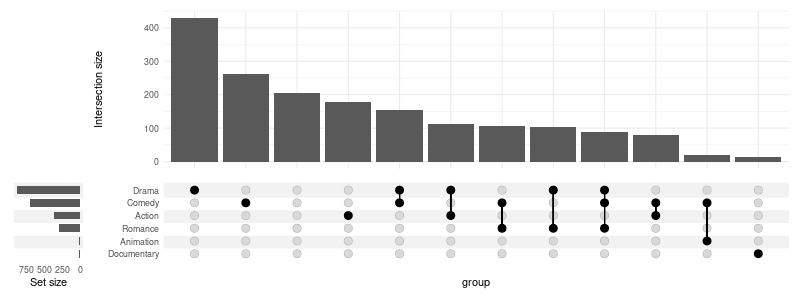

In [12]:
%%R -w 800 -h 300

upset(
    movies,
    genres,
    base_annotations=list(
        'Intersection size'=intersection_size(counts=FALSE)
    ),
    min_size=10,
    width_ratio=0.1
)

The colors can be changed:

[1] "Dropping empty groups: Short"


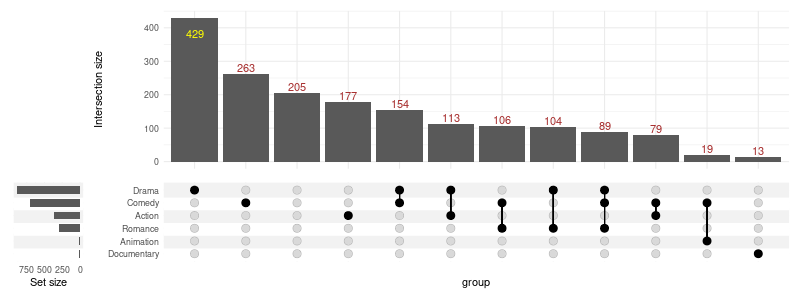

In [13]:
%%R -w 800 -h 300

upset(
    movies,
    genres,
    base_annotations=list(
        'Intersection size'=intersection_size(
            text_colors=c(
                on_background='brown', on_bar='yellow'
            )
        )
    ),
    min_size=10,
    width_ratio=0.1
)

Any parameter supported by `geom_text` can be passed in `text` list:

[1] "Dropping empty groups: Short"


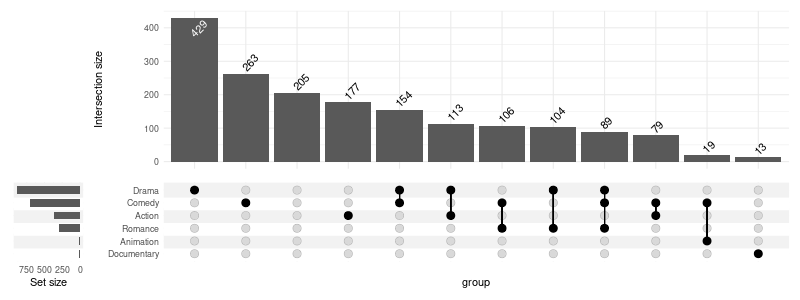

In [14]:
%%R -w 800 -h 300

upset(
    movies,
    genres,
    base_annotations=list(
        'Intersection size'=intersection_size(
            text=list(
                vjust=-0.1,
                hjust=-0.1,
                angle=45
            )
        )
    ),
    min_size=10,
    width_ratio=0.1
)

### 3.2 Fill the bars

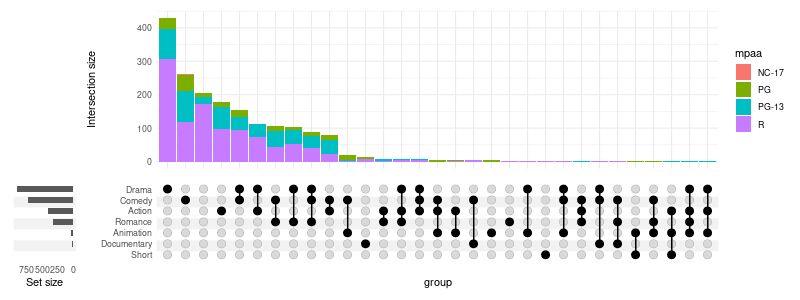

In [15]:
%%R -w 800 -h 300

upset(
    movies,
    genres,
    base_annotations=list(
        'Intersection size'=intersection_size(
            counts=FALSE,
            aes=aes(fill=mpaa)
        )
    ),
    width_ratio=0.1
)

### 3.3 Adjusting the height of the matrix/intersection size

Setting `height_ratio=1` will cause the intersection matrix and the intersection size to have an equal height:

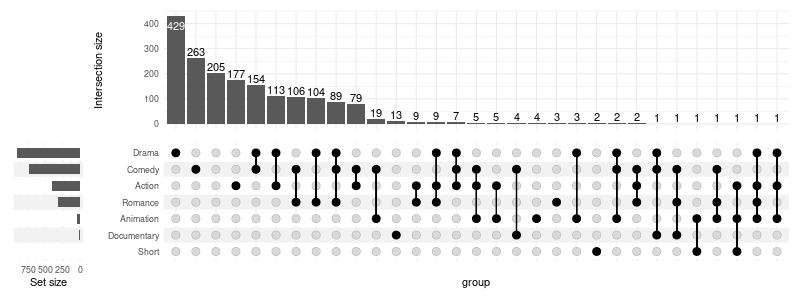

In [16]:
%%R -w 800 -h 300

upset(
    movies,
    genres,
    height_ratio=1,
    width_ratio=0.1
)

### 3.5 Hiding intersection size

You can always disable the intersection size altogether:

[1] "Dropping empty groups: Short"


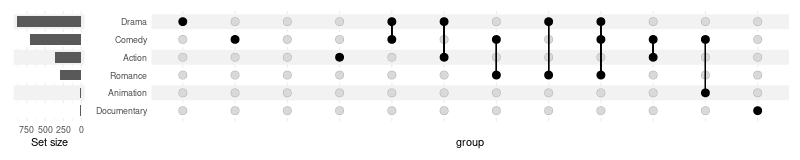

In [17]:
%%R -w 800 -h 160
upset(
    movies,
    genres,
    base_annotations=list(),
    min_size=10,
    width_ratio=0.1
)

### 3.6 Showing intersection size/union size ratio

It can be useful to visualise which intersections are larger than expected by chance (assuming equal probability of belonging to multiple sets); this can be achieved using the intersection size/union size ratio.

> Note: this ratio cannot be computed for the null intersection (observations which do not belong to either of the groups), as denominator would be 0.

> Important note: with early min/max trimming the intersection ratio uses the trimmed denominator. In most cases you probably want to set `min_max_early=FALSE` when plotting ratios with any kind of filtering imposed.

[1] "Dropping empty groups: Short"


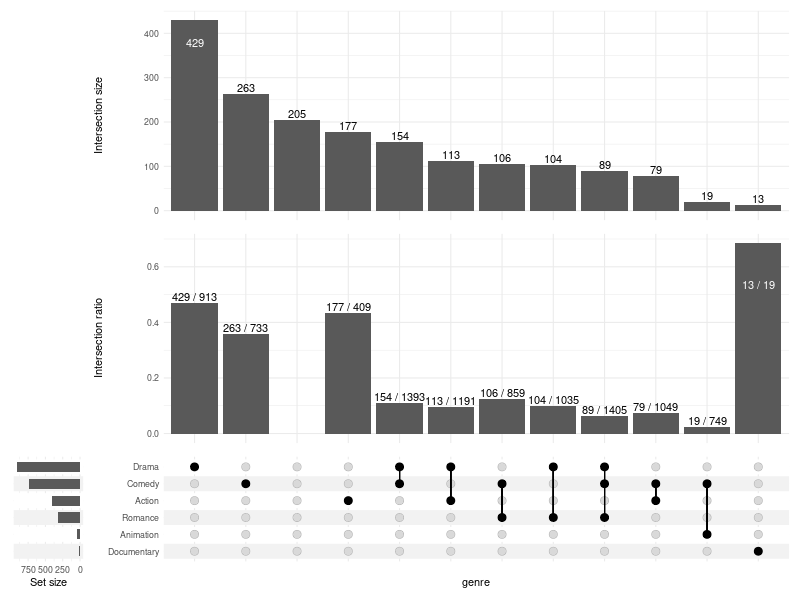

In [18]:
%%R -w 800 -h 600
suppressWarnings(upset(
    movies, genres, name='genre', width_ratio=0.1, min_size=10,
    base_annotations=list(
        'Intersection size'=intersection_size(),
        'Intersection ratio'=intersection_ratio()
    ),
    min_max_early=FALSE
))

The plot above tells us that the analysed documentary movies are almost always (in over 60% of cases) documentaries (and nothing more!), while comedies more often include elements of other genres (e.g. drama, romance) rather than being comedies alone (like stand-up shows).

### 3.7 Showing percentages

`text_aes` can be used to manipulate the aesthetics of the labels. Using the `intersection_size` and `union_size` one can calculate percentage of items in the intersection (relative to the potential size of the intersection). A `upset_text_percentage(digits=0, sep='')` shorthand is provided for convenience; please note that it has to be used with `aes_` rather than `aes`:

[1] "Dropping empty groups: Short"


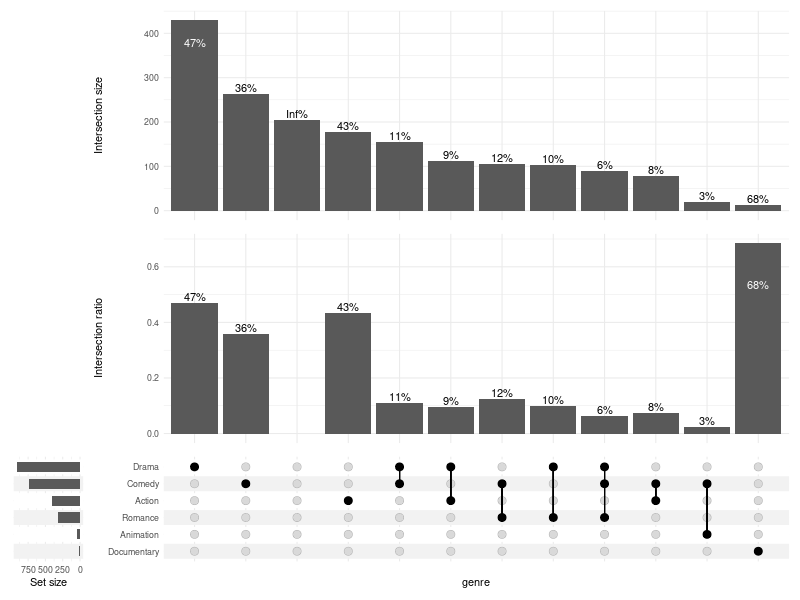

In [19]:
%%R -w 800 -h 600
suppressWarnings(upset(
    movies, genres, name='genre', width_ratio=0.1, min_size=10,
    base_annotations=list(
        # with manual aes specification:
        'Intersection size'=intersection_size(text_aes=aes(label=paste0(round(intersection_size/union_size * 100), '%'))),
        # using shorthand:
        'Intersection ratio'=intersection_ratio(text_aes=aes_(label=upset_text_percentage()))
    ),
    min_max_early=FALSE
))

## 4. Adjusting "set size"

### 4.1 Rotate labels

To rotate the labels modify corresponding theme:

[1] "Dropping empty groups: Animation, Documentary, Short"


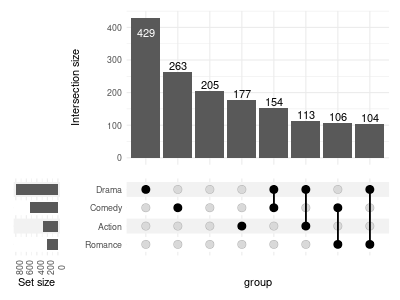

In [20]:
%%R -w 400 -h 300
upset(
    movies, genres,
    min_size=100,
    width_ratio=0.15,
    themes=upset_modify_themes(
        list(
            'overall_sizes'=theme(axis.text.x=element_text(angle=90))
        )
    )
)

To display the ticks:

[1] "Dropping empty groups: Animation, Documentary, Short"


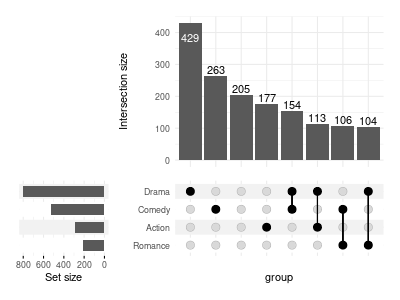

In [21]:
%%R -w 400 -h 300
upset(
    movies, genres, width_ratio=0.3, min_size=100, wrap=TRUE,
    themes=upset_modify_themes(
        list(
            'overall_sizes'=theme(axis.ticks.x=element_line())
        )
    )
)

### 4.2 Modify geoms and other layers

Arguments of the `geom_bar` can be passed to `upset_set_size`; it can even use a different geom, or be replaced with a custom list of layers altogether:

[1] "Dropping empty groups: Documentary, Short"
[1] "Dropping empty groups: Documentary, Short"
[1] "Dropping empty groups: Documentary, Short"


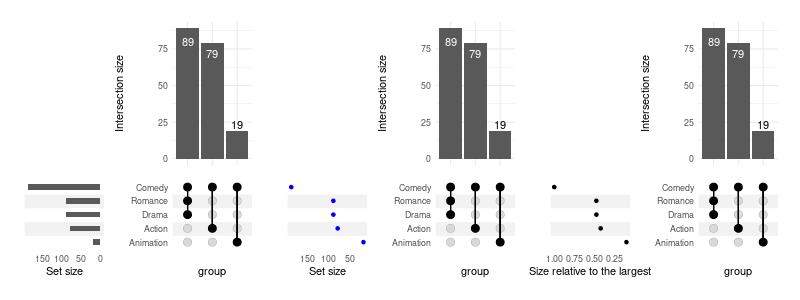

In [22]:
%%R -w 800 -h 300

(
    upset(
        movies, genres, width_ratio=0.5, max_size=100, min_size=15, wrap=TRUE,
        set_sizes=upset_set_size(
            width=0.4
        )
    )
    +
    upset(
        movies, genres, width_ratio=0.5, max_size=100, min_size=15, wrap=TRUE,
        set_sizes=upset_set_size(
            geom=geom_point,
            stat='count',
            color='blue'
        )
    )
    +
    upset(
        movies, genres, width_ratio=0.5, max_size=100, min_size=15, wrap=TRUE,
        set_sizes=list(
            geom_point(aes(y=..count../max(..count..)), stat='count'),
            ylab('Size relative to the largest'),
            scale_y_reverse()
        )
    )
)

### 4.3 Logarithmic scale

In order to use a log scale we need pass additional scale to in `layers` argument. However, as the bars are on flipped coordinates, we need a reversed log transformation:

In [23]:
%%R
reverse_log_trans <- function(base=10) {
    # CC-BY-SA 4.0 Brian Diggs, modified
    # https://stackoverflow.com/a/11054781
    scales::trans_new(
        paste0(
            'reverselog-', format(base)),
            function(x) -log(x, base),
            function(x) base^-x,
            scales::log_breaks(base=base),
            domain = c(1e-100, Inf)
    )
}

Which is then easy to apply:

[1] "Dropping empty groups: Short"


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



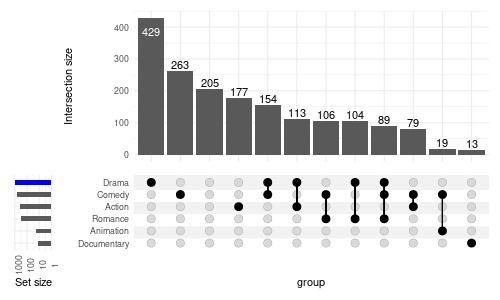

In [24]:
%%R -w 500 -h 300

upset(
    movies, genres,
    width_ratio=0.1,
    min_size=10,
    set_sizes=upset_set_size(
        width=0.4,
        layers=list(
            scale_y_continuous(trans=reverse_log_trans())
        )
    ),
    themes=upset_modify_themes(
        list('overall_sizes'=theme(axis.text.x=element_text(angle=90)))
    ),
    queries=list(upset_query(set='Drama', fill='blue'))
)

We can also modify the labels to display the logged values:

[1] "Dropping empty groups: Short"


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



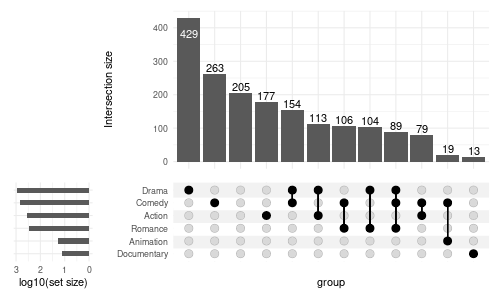

In [25]:
%%R -w 500 -h 300

upset(
    movies, genres,
    min_size=10,
    width_ratio=0.2,
    set_sizes=upset_set_size(
        width=0.4,
        layers=list(
            scale_y_continuous(
                trans=reverse_log_trans(),
                labels=log10
            ),
            ylab('log10(set size)')
        )
    )
)

### 4.4 Hide the set sizes altogether

[1] "Dropping empty groups: Short"


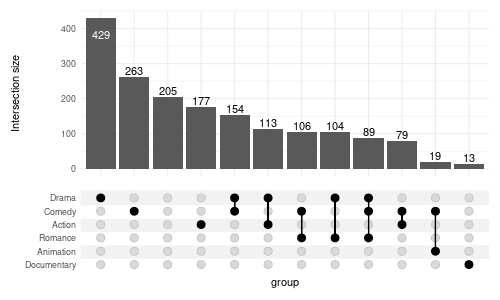

In [26]:
%%R -w 500 -h 300

upset(
    movies, genres,
    min_size=10,
    set_sizes=FALSE
)

## 5. Adjusting other aesthetics

### 5.1 Stripes

Change the colors:

[1] "Dropping empty groups: Short"


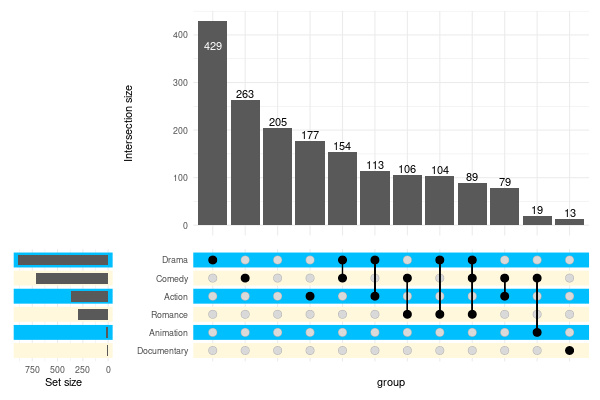

In [27]:
%%R -w 600 -h 400
upset(
    movies,
    genres,
    min_size=10,
    width_ratio=0.2,
    stripes=c('cornsilk1', 'deepskyblue1')
)

You can use multiple colors:

[1] "Dropping empty groups: Short"


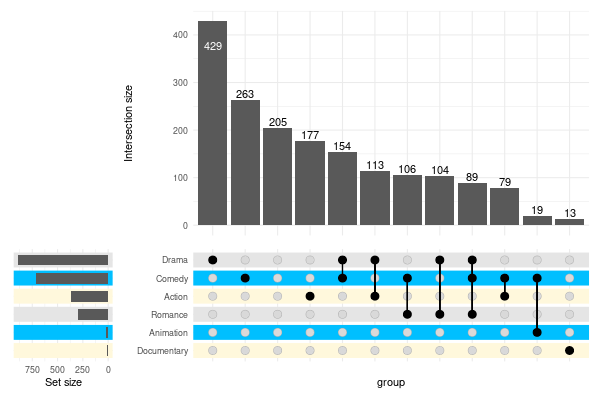

In [28]:
%%R -w 600 -h 400
upset(
    movies,
    genres,
    min_size=10,
    width_ratio=0.2,
    stripes=c('cornsilk1', 'deepskyblue1', 'grey90')
)

Or, set the color to white to effectively disable the stripes:

[1] "Dropping empty groups: Short"


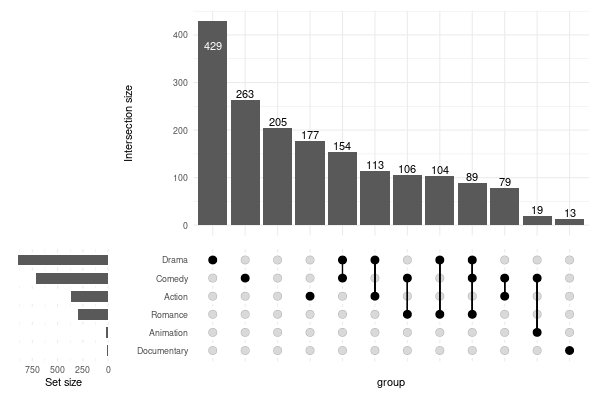

In [29]:
%%R -w 600 -h 400
upset(
    movies,
    genres,
    min_size=10,
    width_ratio=0.2,
    stripes='white'
)

### 5.2 Adding title

Adding title with `ggtitle` with add it to the intersection matrix:

[1] "Dropping empty groups: Short"


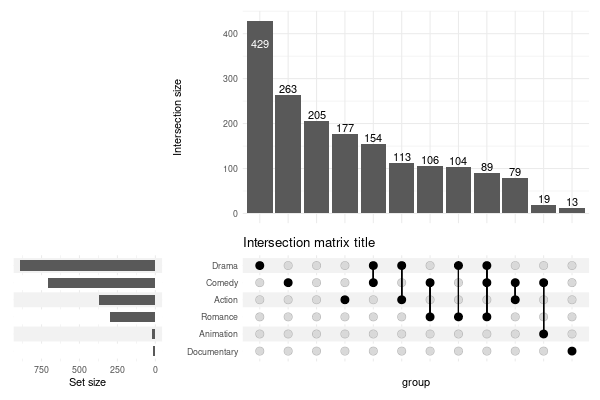

In [30]:
%%R -w 600 -h 400
upset(movies, genres, min_size=10) + ggtitle('Intersection matrix title')

In order to add a title for the entire plot, you need to wrap the plot:

[1] "Dropping empty groups: Short"


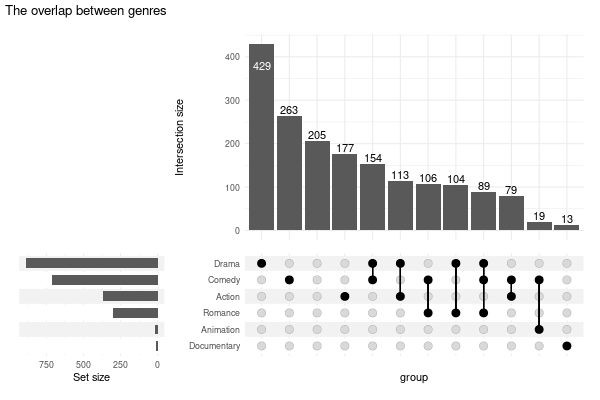

In [31]:
%%R -w 600 -h 400
upset(movies, genres, min_size=10, wrap=TRUE) + ggtitle('The overlap between genres')

### 5.3 Making the plot transparent

You need to set the plot background to transparent and adjust colors of stripes to your liking:

[1] "Dropping empty groups: Short"


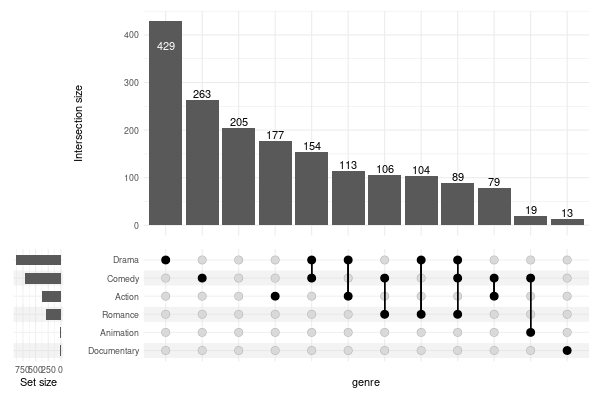

In [32]:
%%R -w 600 -h 400
(
    upset(
        movies, genres, name='genre', width_ratio=0.1, min_size=10,
        stripes=c(alpha('grey90', 0.45), alpha('white', 0.3))
    )
    & theme(plot.background=element_rect(fill='transparent', color=NA))
)

Use `ggsave('upset.png', bg="transparent")` when exporting to PNG.

## 6. Themes

The themes for specific components are defined in `upset_themes` list, which contains themes for:

In [33]:
%%R
names(upset_themes)

[1] "intersections_matrix" "Intersection size"    "overall_sizes"       
[4] "default"             


You can substitute this list for your own using `themes` argument. While you can specify a theme for every component, if you omit one or more components those will be taken from the element named `default`.

### 6.1 Substituting themes

[1] "Dropping empty groups: Short"


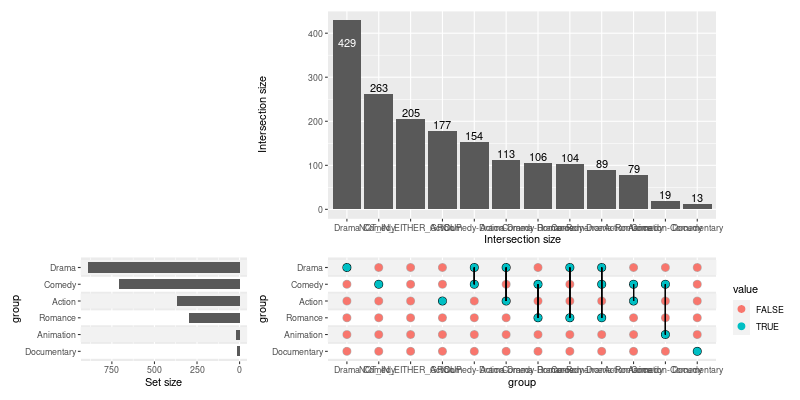

In [34]:
%%R -w 800 -h 400
upset(movies, genres, min_size=10, themes=list(default=theme()))

You can also add themes for your custom panels/annotations:

[1] "Dropping empty groups: Short"


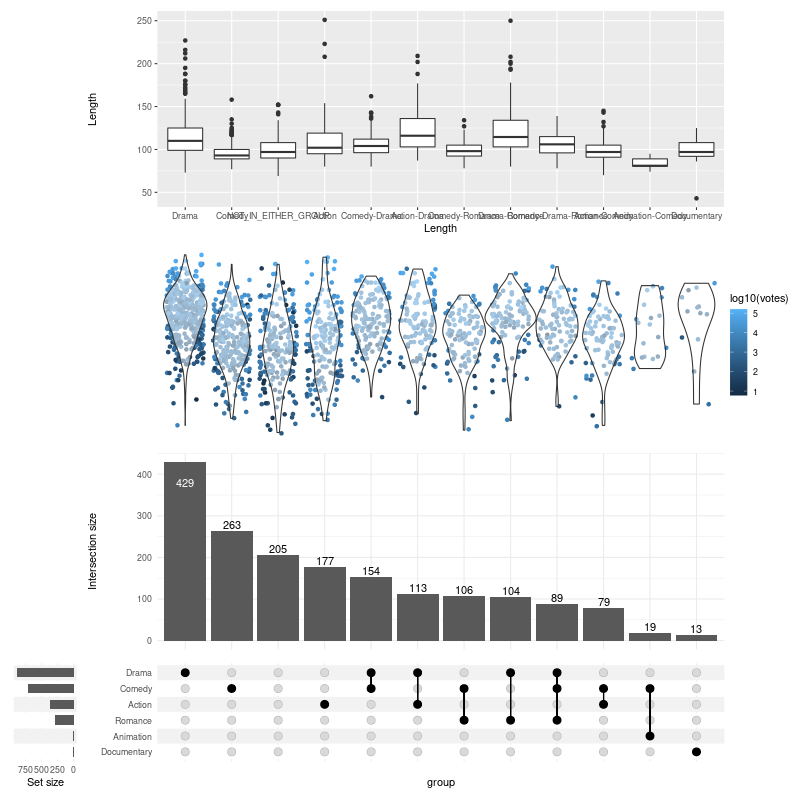

In [35]:
%%R -w 800 -h 800

upset(
    movies,
    genres,
    annotations = list(
        'Length'=list(
            aes=aes(x=intersection, y=length),
            geom=geom_boxplot()
        ),
        'Rating'=list(
            aes=aes(x=intersection, y=rating),
            geom=list(
                geom_jitter(aes(color=log10(votes))),
                geom_violin(width=1.1, alpha=0.5)
            )
        )
    ),
    min_size=10,
    width_ratio=0.1,
    themes=modifyList(
        upset_themes,
        list(Rating=theme_void(), Length=theme())
    )
)

### 6.2 Adjusting the default themes

Modify all the default themes as once with `upset_default_themes()`:

[1] "Dropping empty groups: Short"


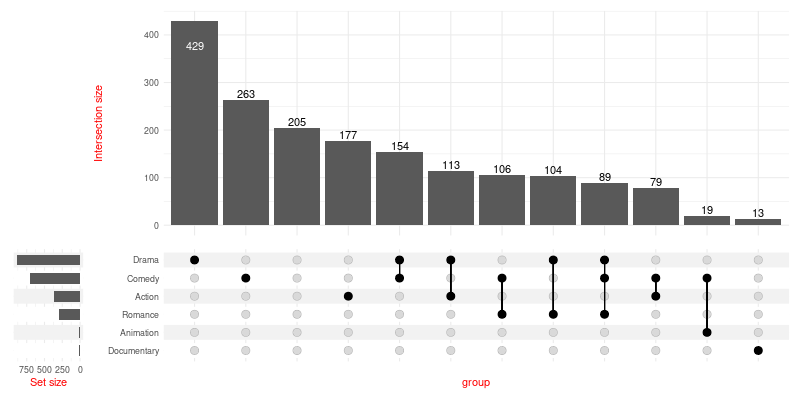

In [36]:
%%R -w 800 -h 400

upset(
    movies, genres, min_size=10, width_ratio=0.1,
    themes=upset_default_themes(text=element_text(color='red'))
)

To modify only a subset of default themes use `upset_modify_themes()`:

[1] "Dropping empty groups: Animation, Documentary, Short"


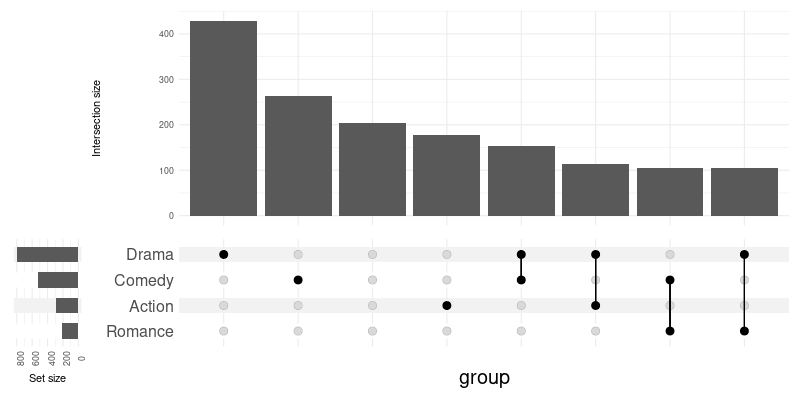

In [37]:
%%R -w 800 -h 400

upset(
    movies, genres,
    base_annotations=list('Intersection size'=intersection_size(counts=FALSE)),
    min_size=100,
    width_ratio=0.1,
    themes=upset_modify_themes(
        list(
            'intersections_matrix'=theme(text=element_text(size=20)),
            'overall_sizes'=theme(axis.text.x=element_text(angle=90))
        )
    )
)

## 7. Highlighting (queries)

Pass a list of lists generated with `upset_query()` utility to the optional `queries` argument to selectively modify aesthetics of specific intersections or sets.

Use one of the arguments: `set` or `intersection` (not both) to specify what to highlight:
- `set` will highlight the bar of the set size,
- `intersection` will highlight an intersection on all components (by default), or on components chosen with `only_components`
- all other parameters will be used to modify the geoms

[1] "Dropping empty groups: Short"


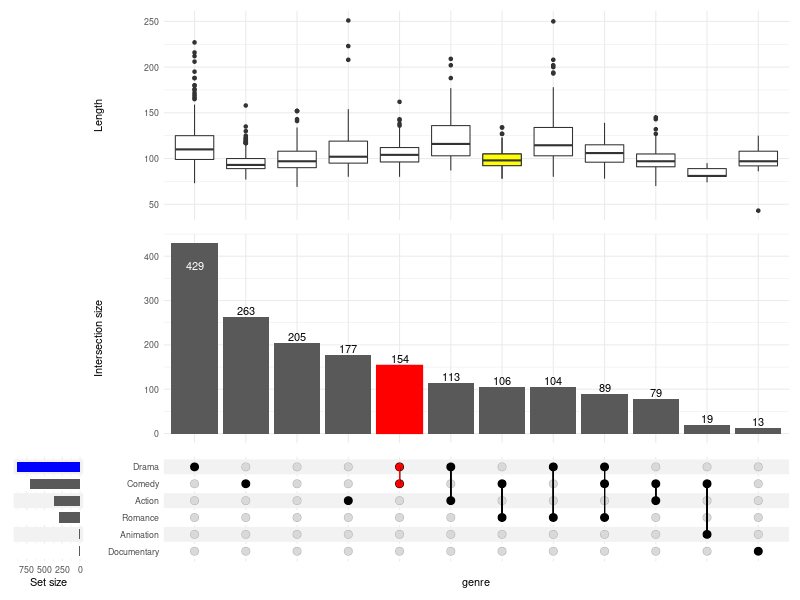

In [38]:
%%R -w 800 -h 600

upset(
    movies, genres, name='genre', width_ratio=0.1, min_size=10,
    annotations = list(
        'Length'=list(
            aes=aes(x=intersection, y=length),
            geom=geom_boxplot()
        )
    ),
    queries=list(
        upset_query(
            intersect=c('Drama', 'Comedy'),
            color='red',
            fill='red',
            only_components=c('intersections_matrix', 'Intersection size')
        ),
        upset_query(
            set='Drama',
            fill='blue'
        ),
        upset_query(
            intersect=c('Romance', 'Comedy'),
            fill='yellow',
            only_components=c('Length')
        )
    )
)

## 8. Sorting

### 8.1 Sorting intersections

By degree:

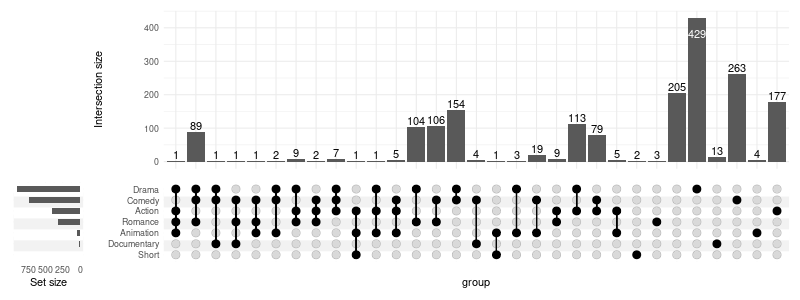

In [39]:
%%R -w 800 -h 300
upset(movies, genres, width_ratio=0.1, sort_intersections_by='degree')

By ratio:

[1] "Dropping empty groups: Short"


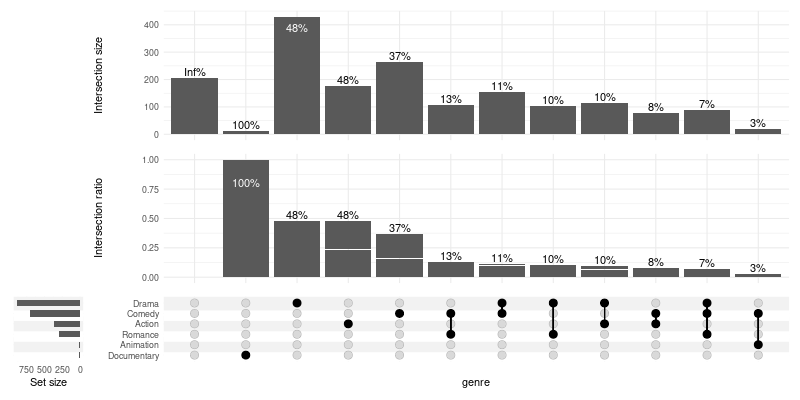

In [40]:
%%R -w 800 -h 400
upset(
    movies, genres, name='genre', width_ratio=0.1, min_size=10,
    sort_intersections_by='ratio',
    base_annotations=list(
        'Intersection size'=intersection_size(text_aes=aes_(label=upset_text_percentage())),
        'Intersection ratio'=intersection_ratio(text_aes=aes_(label=upset_text_percentage()))
    )
)

The other way around:

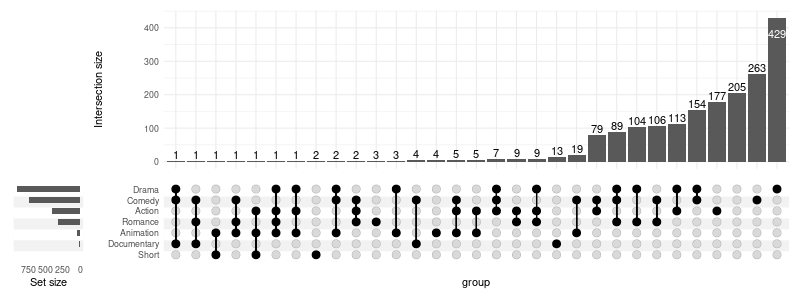

In [41]:
%%R -w 800 -h 300
upset(movies, genres, width_ratio=0.1, sort_intersections='ascending')

Without any sorting:

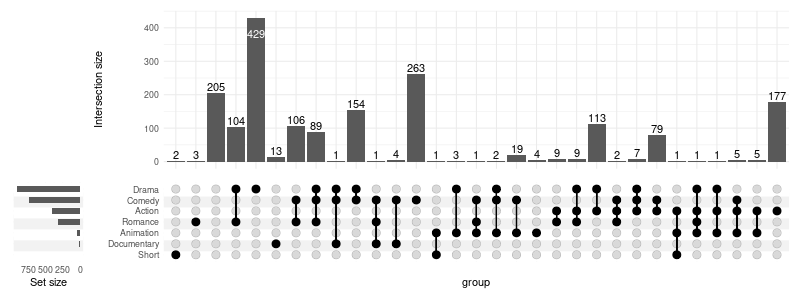

In [42]:
%%R -w 800 -h 300
upset(movies, genres, width_ratio=0.1, sort_intersections=FALSE)

### 8.2 Sorting sets

Ascending:

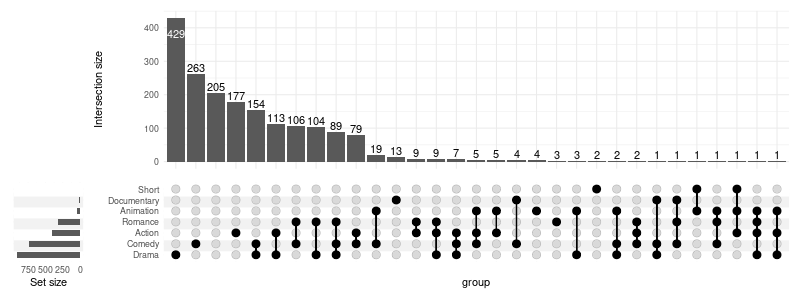

In [43]:
%%R -w 800 -h 300
upset(movies, genres, width_ratio=0.1, sort_sets='ascending')

Without sorting - preserving the order as in genres:

In [44]:
genres

['Action', 'Animation', 'Comedy', 'Drama', 'Documentary', 'Romance', 'Short']

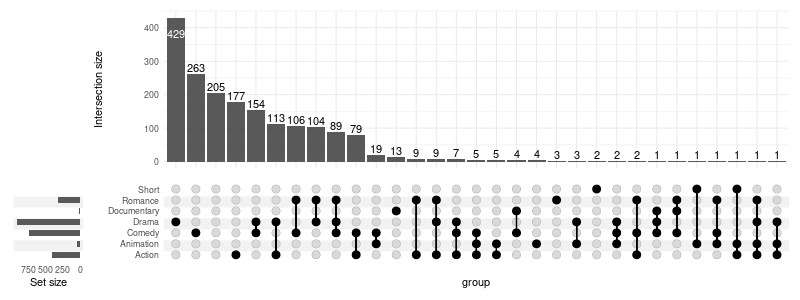

In [45]:
%%R -w 800 -h 300
upset(movies, genres, width_ratio=0.1, sort_sets=FALSE)

## 9. Grouping

### 9.1 Grouping intersections

Use `group_by='sets'` to group intersections by set. If needed, the intersections will be repeated so that they appear in each set group. Use `upset_query()` with `group` argument to color the intersection matrix accordingly.

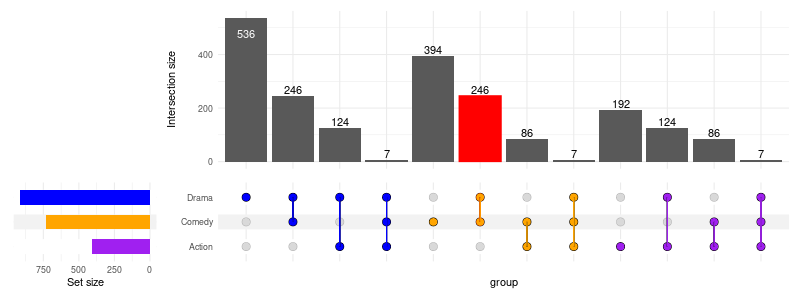

In [46]:
%%R -w 800 -h 300

upset(
    movies, c("Action", "Comedy", "Drama"),
    width_ratio=0.2,
    group_by='sets',
    queries=list(
        upset_query(
            intersect=c('Drama', 'Comedy'),
            color='red',
            fill='red',
            only_components=c('intersections_matrix', 'Intersection size')
        ),
        upset_query(group='Drama', color='blue'),
        upset_query(group='Comedy', color='orange'),
        upset_query(group='Action', color='purple'),
        upset_query(set='Drama', fill='blue'),
        upset_query(set='Comedy', fill='orange'),
        upset_query(set='Action', fill='purple')
    )
)

## 10. Display percentages

Use `aes_percentage()` utility preceeded with `!!` syntax to easily display percentages. In the examples below only percentages for the movies with R raiting are shown to avoid visual clutter.

In [47]:
%%R
raiting_scale = scale_fill_manual(values=c(
    'R'='#E41A1C', 'PG'='#377EB8',
    'PG-13'='#4DAF4A', 'NC-17'='#FF7F00'
))
show_hide_scale = scale_color_manual(values=c('show'='black', 'hide'='transparent'), guide=FALSE)

### 10.1 Within intersection

[1] "Dropping empty groups: Animation, Documentary, Short"


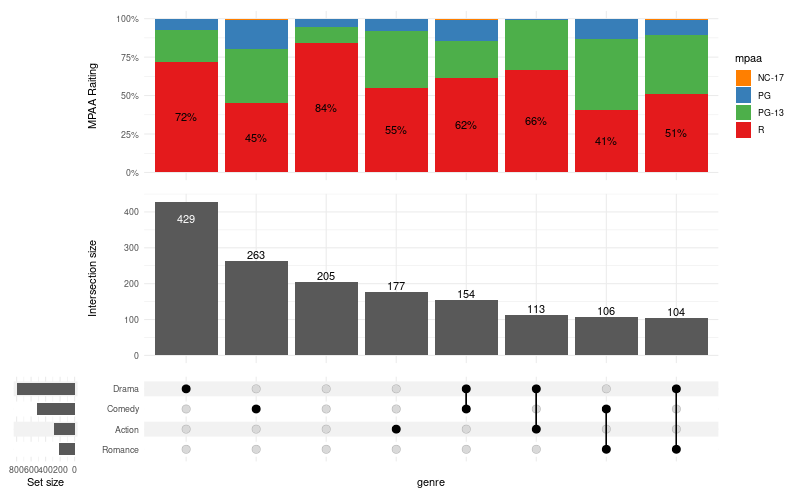

In [48]:
%%R -w 800 -h 500

upset(
    movies, genres, name='genre', width_ratio=0.1, min_size=100,
    annotations =list(
        'MPAA Raiting'=list(
            aes=aes(x=intersection, fill=mpaa),
            geom=list(
                geom_bar(stat='count', position='fill'),
                geom_text(
                    aes(
                        label=!!aes_percentage(relative_to='intersection'),
                        color=ifelse(mpaa == 'R', 'show', 'hide')
                    ),
                    stat='count',
                    position=position_fill(vjust = .5)
                ),
                scale_y_continuous(labels=scales::percent_format()),
                show_hide_scale,
                raiting_scale
            )
        )
    )
)

### 10.2 Relative to the group

[1] "Dropping empty groups: Animation, Documentary, Short"


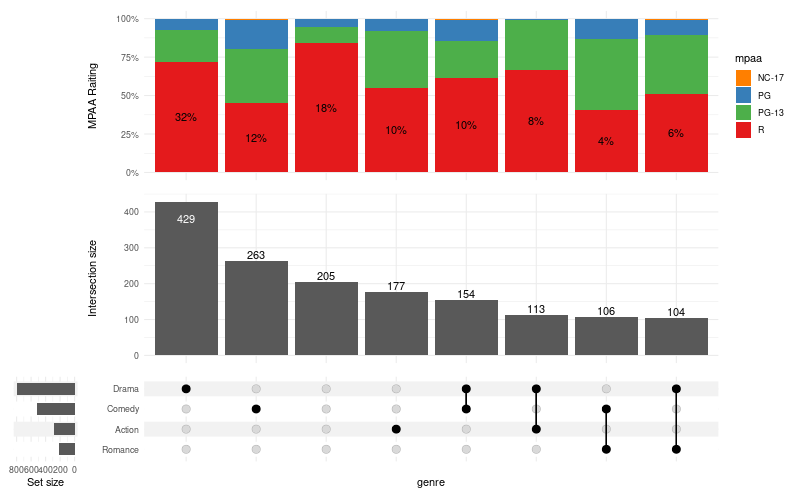

In [49]:
%%R -w 800 -h 500

upset(
    movies, genres, name='genre', width_ratio=0.1, min_size=100,
    annotations =list(
        'MPAA Raiting'=list(
            aes=aes(x=intersection, fill=mpaa),
            geom=list(
                geom_bar(stat='count', position='fill'),
                geom_text(
                    aes(
                        label=!!aes_percentage(relative_to='group'),
                        group=mpaa,
                        color=ifelse(mpaa == 'R', 'show', 'hide')
                    ),
                    stat='count',
                    position=position_fill(vjust = .5)
                ),
                scale_y_continuous(labels=scales::percent_format()),
                show_hide_scale,
                raiting_scale
            )
        )
    )
)


### 10.3 Relative to all observed values

[1] "Dropping empty groups: Animation, Documentary, Short"


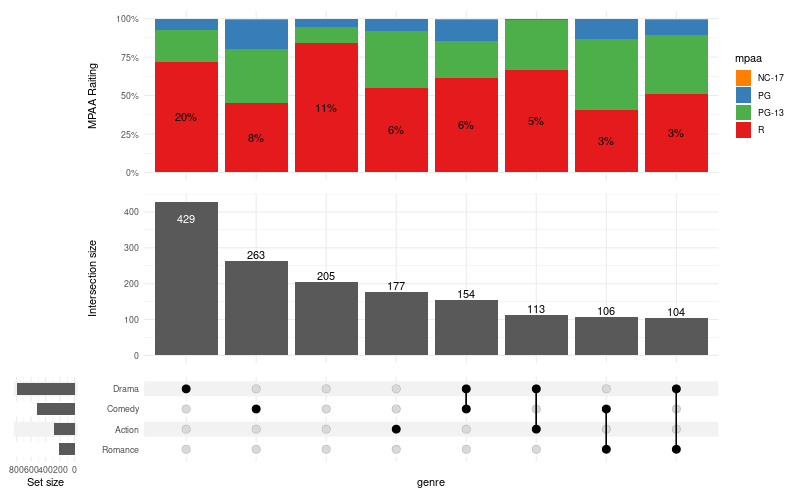

In [50]:
%%R -w 800 -h 500

upset(
    movies, genres, name='genre', width_ratio=0.1, min_size=100,
    annotations =list(
        'MPAA Raiting'=list(
            aes=aes(x=intersection, fill=mpaa),
            geom=list(
                geom_bar(stat='count', position='fill'),
                geom_text(
                    aes(
                        label=!!aes_percentage(relative_to='all'),
                        color=ifelse(mpaa == 'R', 'show', 'hide')
                    ),
                    stat='count',
                    position=position_fill(vjust = .5)
                ),
                scale_y_continuous(labels=scales::percent_format()),
                show_hide_scale,
                raiting_scale
            )
        )
    )
)

## 11. Advanced usage examples

### 11.1 Display text on some bars only

[1] "Dropping empty groups: Animation, Documentary, Short"


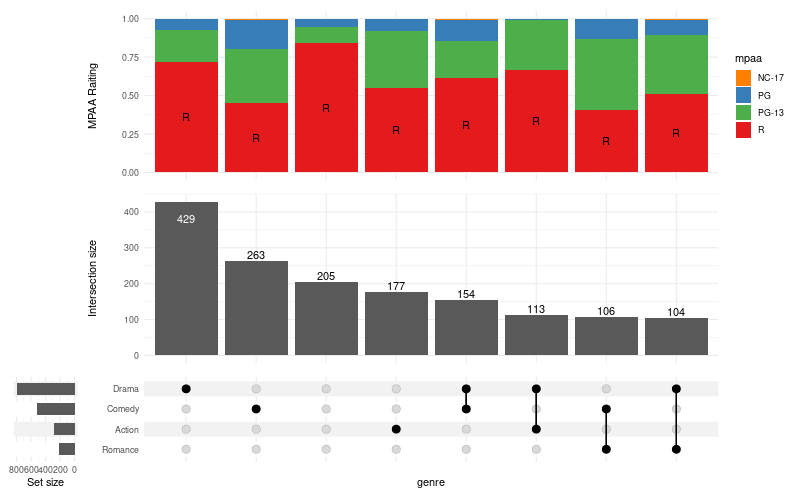

In [51]:
%%R -w 800 -h 500

upset(
    movies, genres, name='genre', width_ratio=0.1, min_size=100,
    annotations =list(
        'MPAA Raiting'=list(
            aes=aes(x=intersection, fill=mpaa),
            geom=list(
                geom_bar(stat='count', position='fill'),
                geom_text(
                    aes(label=ifelse(mpaa == 'R', 'R', NA)),
                    stat='count',
                    position=position_fill(vjust = .5)
                ),
                show_hide_scale,
                raiting_scale
            )
        )
    )
)

### 11.2 Combine multiple plots together

[1] "Dropping empty groups: Animation, Documentary, Short"
[1] "Dropping empty groups: Animation, Documentary, Short"


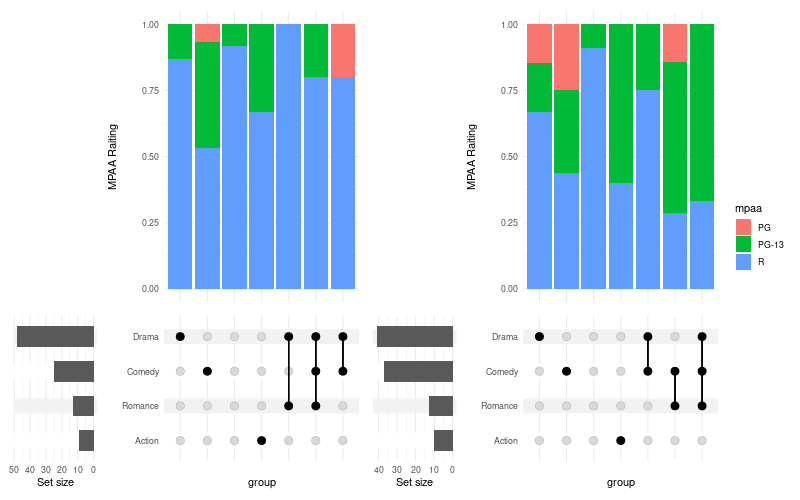

In [52]:
%%R -w 800 -h 500
library(patchwork)

annotations = list(
    'MPAA Raiting'=list(
        aes=aes(x=intersection, fill=mpaa),
        geom=list(
            geom_bar(stat='count', position='fill')
        )
    )
)
set.seed(0)    # for replicable example only

data_1 = movies[sample(nrow(movies), 100), ]
data_2 = movies[sample(nrow(movies), 100), ]

u1 = upset(data_1, genres, min_size=5, base_annotations=annotations)
u2 = upset(data_2, genres, min_size=5, base_annotations=annotations)

(u1 | u2) + plot_layout(guides='collect')